In this notebook I try to reproduce the result from the paper (https://arxiv.org/pdf/1506.02142.pdf) for MNIST classification. The goal is to obtain uncertainty estimation based on dropouts. The plan is the following:
1. Train a fully connected NN with three layers, three dropouts and sigmoid activation
2. Pick an image with label "1" and make a set of rotated copies of it
3. Make a prediction distributions for each image. Plot predictions (mean + std) of label "1" as a function of angle. Plot prediction of labels "2" and "4" for comparison.
4. Repeat steps 1-3 for different dropout probabilities
5. Repeat steps 1-4 for different activation functions

In [6]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from PIL import Image

In [82]:
#MNIST classification FC network adopted from somewhere in the Internet and slightly modified
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 15
batch_size = 100
learning_rate = 0.001
dropout_prob = 0
activation = 'ReLU' #for convenience it is listed here

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.dropout0(x)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

torch.save(model.state_dict(), 'model.ckpt')



Epoch [1/15], Step [100/600], Loss: 0.3331
Epoch [1/15], Step [200/600], Loss: 0.1663
Epoch [1/15], Step [300/600], Loss: 0.1573
Epoch [1/15], Step [400/600], Loss: 0.1754
Epoch [1/15], Step [500/600], Loss: 0.0864
Epoch [1/15], Step [600/600], Loss: 0.0981
Epoch [2/15], Step [100/600], Loss: 0.0857
Epoch [2/15], Step [200/600], Loss: 0.0437
Epoch [2/15], Step [300/600], Loss: 0.0436
Epoch [2/15], Step [400/600], Loss: 0.0743
Epoch [2/15], Step [500/600], Loss: 0.1020
Epoch [2/15], Step [600/600], Loss: 0.0383
Epoch [3/15], Step [100/600], Loss: 0.1328
Epoch [3/15], Step [200/600], Loss: 0.0355
Epoch [3/15], Step [300/600], Loss: 0.1034
Epoch [3/15], Step [400/600], Loss: 0.0287
Epoch [3/15], Step [500/600], Loss: 0.1140
Epoch [3/15], Step [600/600], Loss: 0.0093
Epoch [4/15], Step [100/600], Loss: 0.0056
Epoch [4/15], Step [200/600], Loss: 0.0224


KeyboardInterrupt: 

In [83]:
index = 5
for test_images, test_labels in test_loader:  
    sample_image = test_images[index]    
    sample_label = test_labels[index]
    break

In [84]:
#making set of rotated images
mod_images = []
for i in range(10):
    mod_image = torch.Tensor(np.array(Image.fromarray(sample_image.view(28,28).detach().numpy()).rotate(-i*10))).view(1,28,28)
    mod_images.append(mod_image)

tensor([[ -7.7800,  10.9640,  -3.5322,  -5.9762,   0.5149,  -7.4748, -10.0554,
           3.1396,  -3.6777,  -4.5977]], grad_fn=<AddmmBackward>)


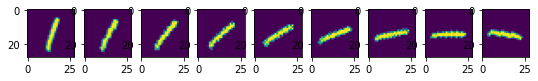

In [85]:
print(model(mod_images[1].reshape(-1,784)))
fig = plt.figure(figsize=(9,1))
for i in range(9):
    fig.add_subplot(int('19{}'.format(i+1)))
    plt.imshow(mod_images[i].view(28,28))

In [86]:
#we need a portion of binary vectors to get a distribution of prediction
from scipy.stats import bernoulli
def bernoulli_diagonal(mat):
    p = 1-dropout_prob
    r = torch.Tensor(bernoulli.rvs(p, size=mat.shape[1]))
    ind = np.diag_indices(mat.shape[1])
    diag_mat = torch.zeros((mat.shape[1], mat.shape[1]))
    diag_mat[ind[0], ind[1]] = r
    return torch.Tensor(diag_mat)

In [87]:
#actual distribution generation
def distr_gen(model, sample_image, T):
    distr = np.zeros((T,10))
    for t in range(T):
        model_copy = copy.deepcopy(model)
    
        data = model_copy.fc1.weight.data
        diag = bernoulli_diagonal(data)
        dropout_data = torch.matmul(data,diag)
        model_copy.fc1.weight = nn.Parameter(dropout_data)
    
        data = model_copy.fc2.weight.data
        diag = bernoulli_diagonal(data)
        dropout_data = torch.matmul(data,diag)
        model_copy.fc2.weight = nn.Parameter(dropout_data)
    
        data = model_copy.fc3.weight.data
        diag = bernoulli_diagonal(data)
        dropout_data = torch.matmul(data,diag)
        model_copy.fc3.weight = nn.Parameter(dropout_data)
    
        distr[t] = model_copy(sample_image.reshape(-1,784)).detach().numpy()[0]
    return distr

In [88]:
#generate distributions of predictions for all angles
distrs = []
for i in range(10):
    distrs.append(distr_gen(model,mod_images[i],100))

In [89]:
means = np.zeros((10,10))
stds = np.zeros((10,10))
tau=10
for i in range(10):
    mean = np.mean(distrs[i],axis=0)
    means[i] = mean
    covariance = 1/tau*np.identity(len(mean))
    covariance += np.mean(np.array([np.outer(x,x) for x in distrs[i]]),axis=0) - np.outer(mean,mean)
    std = np.sqrt(covariance.diagonal())
    stds[i] = std    

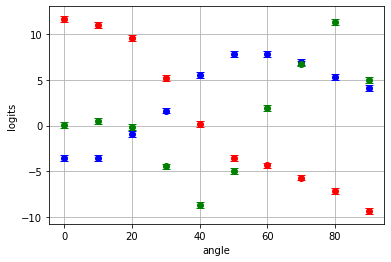

actual predictions:  [1 1 1 1 2 2 2 2 4 4]


In [90]:
X = np.arange(10)*10
plt.errorbar(X, means[:,1], yerr=stds[:,1], fmt='ro',capsize=4)
plt.errorbar(X, means[:,2], yerr=stds[:,2], fmt='bo',capsize=4)
plt.errorbar(X, means[:,4], yerr=stds[:,4], fmt='go',capsize=4)
plt.xlabel('angle')
plt.ylabel('logits')
plt.grid(True)
plt.savefig('dp={}, {}.png'.format(dropout_prob, activation))
plt.show()
print('actual predictions: ',np.argmax(means, axis=1))

As wee see from the plot, prediction distributions do overlap as the image rotates. We may develop an uncertainty criterion from there: if overlapping is not significant than the prediction is okay. This overlapping grows if dropout probability increases, so uncertainty is smaller if overlapping is small for bigger dropout probability.